In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from math import sqrt
from scipy.optimize import curve_fit, minimize
from scipy import stats
import string
import matplotlib.ticker as ticker
import string
import numpy.ma as ma
from astropy.io import ascii
from scipy.optimize import curve_fit
from astropy.io import fits

plt.rc('font', size=10)
# ----- Load Input ----- #
DFLAG = ''                     # Data Flag. Set to '' for Fiducial MICE. '_Octant' for MICE Octant.
Include_mCov = True            # Include the uncertainty due to the m-correction
Include_mBias = True           # If True, read in and bias the gamma_t by *(1 + m + f_mBias * m_err)
f_mBias = 5                    # where f_mBias (no. of sigmas to bias by) is defined below.

Include_Hartlap = False        # Hartlap correction

Include_IA = False              # If True, read in the kcap prediction for the IA-only <g_t> and inflate the cov diag by
f_IA = 0                       # +(f_IA* gt_IA)^2 ; f_IA is our uncert. on IA amplitude.
A_IA = 1                       # A_IA*gt_IA is added to the fitted model if Include_IA is True.

Single_Bin = False             # If True, fit for only a single lens-source bin, specified by user on the command line.
                               # Else fit for all bins simultaneously.
                               
nofz_shift=""       # Only for K1000: use the Dls/Ds values for the nofz which has been
                               # shifted up ('_nofzUp'), down ('_nofzDown') by +/-(delta_z+delta_z_err)
                               # OR 5sig shift-up ('_nofzUp5sig'), down ('_nofzDown5sig') by (+/- 5*delta_z_err)
                               # For no shift, set to ''.
                               # Finally, to include the uncert. on the nofz's in the SRT modelling,
                               # set nofz_shift to "_ModnofzUpDown"
                               
from Get_Input import Get_Input
paramfile = 'param_files/params_K1000_BOSS_BlindC_SOMFid.dat'   # e.g. params_KiDSdata.dat
GI = Get_Input(paramfile)
SOURCE_TYPE = GI.Source_Type()
LENS_TYPE = GI.Lens_Type()
RANDOM_TYPE = GI.Random_Type()



spec_bins=range(5)
tomo_bins=range(5)
ntomo=len(tomo_bins)              # Number of photo-z bins
nspecz=len(spec_bins)             # "..." of spec-z bins
if ntomo==5 and nspecz==5:
    save_tag = ''                 # Blank save_tag means SRT was conducted on all lens & source bins
else:
    save_tag = '_%stbins-%ssbins' %(ntomo,nspecz) # Using more than a single t&s bin,
                                                    # but not all 5x5
    
numz_tag=5               # Part of 'GT_' filenames; GT_6Z_source_Y_${numz_tag}Z_lens_X.asc
ntheta = 4
theta_min = 2.
theta_max = 30.

measurements = {}

thetas_list = []  
gt_list = []      # gamma_t
gx_list = []      # gamma_x
gterr_list = []
gt_list_m = []      # gamma_t
gx_list_m = []      # gamma_x
gterr_list_m = []

# The following two are used to construct the analytical covariance
# and are only read in if Cov_Method="Analytical"
weight_sqrd_list = []  # the weight returned from the lens-source correlation with squared weights
ran_weight_list = []

tomo_list = []
speczbin_list = []
Dls_over_Ds_list = []
Dls_over_Ds_list_UP = []   # These two lists only get used if you are reading in the Dls/Ds for BOTH the
Dls_over_Ds_list_DOWN = [] # nofz shift up/down, and including this extra uncert. in the fitting
                           # (i.e. only if nofz_shift is set to "_ModnofzUpDown")


Cov_Method = "Spin"   # The method for calculating the gamma_t realisations for use in covariance estimation
                       # "Spin" many spin realisations of the source ellipticities (ie - shape noise only)
                       # "Patch" using other MICE realisations (1/8 of the sky)
                       # divided them into patches and calcuted the gamma_t from each patch.
                       # "Analytical" means construct and use an analytical covariance matrix.
                       
nPatch = 16             # If Cov_Method is Patch, the MICE octant is split into nPatch RA
                       # and nPatch Dec slices (nPatch^2 patches in total). gamma_t is
                       # calculated from each patch.   


INDIR='Output/SOURCE-%s_LENS-%s_BlindC_SOMFalse' %(SOURCE_TYPE, LENS_TYPE)
DlsDIR='Dls_over_Ds_data/SOURCE-%s_LENS-%s_BlindC_SOMFid_OutlierPeaksInBins12345' %(SOURCE_TYPE, LENS_TYPE)

Blind = GI.Blind()
SOMFLAGNAME = GI.SOMFLAGNAME()
OL_Tag = GI.OL_Tag() # Whether a high-z outlier is included in n(z)'s
                        # that went into the Dls/Ds ratios
# INDIR += '_Blind%s_SOM%s' %(Blind,SOMFLAGNAME)
# DlsDIR += '_Blind%s_SOM%s%s' %(Blind,SOMFLAGNAME, OL_Tag)
save_tag += OL_Tag

if Include_mBias:
    # Read in the m-bias and error per tomo_bin
    mBias, mBias_err = np.loadtxt('mbias_perbin_mean_err.asc', usecols=(0,1), unpack=True)
    #mBias_err[1] *= -1
    #mBias_err[3] *= -1
else:
    mBias = np.zeros(tomo_bins[-1]+1)
    mBias_err = np.zeros_like( mBias )
    
nspin=500
if Cov_Method == "Spin" or Cov_Method == "Analytical":
    ncycle = nspin
    OUTDIR = INDIR + "/SPIN/"
    Area_Scale = 1. #341./777. # Approx. scaling KV450-->K1000     #1.
elif Cov_Method == "Patch":
    ncycle = nPatch*nPatch
    OUTDIR = INDIR + "/PATCH/"
    Area_Scale = 4*np.pi *(180./np.pi)**2. / 343.
else:
    print("Cov_Method must be set to Spin or Patch. Currently it's set to %s. EXITING." %Cov_Method)
    sys.exit()
for speczbin in spec_bins:
    for tomobin in tomo_bins:
        print("Reading tomo bin %s, spec bin %s" %(tomobin+1, speczbin+1))
        gtfile='%s/GT_6Z_source_%s_%sZ_lens_%s%s.asc' %(INDIR,(tomobin+1), numz_tag,(speczbin+1), DFLAG)

        gtdat=ascii.read(gtfile)

        measurements['thetas_'+str(speczbin)+"_"+str(tomobin)] = gtdat['meanr']
        measurements['gt_'+str(speczbin)+"_"+str(tomobin)]     = gtdat['gamT']
        measurements['gx_'+str(speczbin)+"_"+str(tomobin)]     = gtdat['gamX']
        measurements['gterr_'+str(speczbin)+"_"+str(tomobin)]  = gtdat['sigma']

        thetas_list.append(measurements['thetas_'+str(speczbin)+"_"+str(tomobin)])
        gt_list_m.append(measurements['gt_'+str(speczbin)+"_"+str(tomobin)]*( 1+(mBias+f_mBias*mBias_err)[tomobin]))
        gx_list_m.append(measurements['gx_'+str(speczbin)+"_"+str(tomobin)]*( 1+(mBias+f_mBias*mBias_err)[tomobin] ))
        gterr_list_m.append(measurements['gterr_'+str(speczbin)+"_"+str(tomobin)]*( 1+(mBias+f_mBias*mBias_err)[tomobin] ))
        gt_list.append(measurements['gt_'+str(speczbin)+"_"+str(tomobin)])
        gx_list.append(measurements['gx_'+str(speczbin)+"_"+str(tomobin)])
        gterr_list.append(measurements['gterr_'+str(speczbin)+"_"+str(tomobin)])
        
        tomo_list.append(tomobin*np.ones((ntheta),dtype=np.int16))
        speczbin_list.append(speczbin*np.ones((ntheta),dtype=np.int16))

        # Read in the Dls_over_Ds data created with Dls_over_Ds.py
        # Either read in ONLY the nofz shift up/down/no-shift...
        # OR read in all, and incorporate the uncertainty on mean-z into the fitting.
        Dls_over_Ds_file = '%s/Dls_over_Ds_DIR_6Z_source_%s_%sZ_lens_%s' %(DlsDIR, (tomobin+1), numz_tag,(speczbin+1))
        if nofz_shift == "_ModnofzUpDown":
            #Read in both nofz shift up and down (later use them to inflate the errors on the covariance):
            Dls_over_Ds_tmp_up = np.loadtxt(Dls_over_Ds_file+'_nofzUp.asc')
            Dls_over_Ds_tmp_down = np.loadtxt(Dls_over_Ds_file+'_nofzDown.asc')
            Dls_over_Ds_tmp = np.loadtxt(Dls_over_Ds_file+'.asc')
            
            measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)+"_UP"] = np.repeat(Dls_over_Ds_tmp_up, ntheta)
            measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)+"_DOWN"] = np.repeat(Dls_over_Ds_tmp_down, ntheta)
            measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)] = np.repeat(Dls_over_Ds_tmp, ntheta)

            Dls_over_Ds_list_UP.append(measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)+"_UP"])
            Dls_over_Ds_list_DOWN.append(measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)+"_DOWN"])
            Dls_over_Ds_list.append(measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)])
            
        else:
            Dls_over_Ds_tmp = np.loadtxt(Dls_over_Ds_file+'%s.asc' %nofz_shift)
            measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)] = np.repeat(Dls_over_Ds_tmp,ntheta)
            Dls_over_Ds_list.append(measurements['Dls_over_Ds_'+str(speczbin)+"_"+str(tomobin)])
        
thetas = np.hstack(thetas_list)
tomo = np.hstack(tomo_list)
speczbin = np.hstack(speczbin_list)
gt = np.hstack(gt_list) 
gx = np.hstack(gx_list) 
gterr = np.hstack(gterr_list)
gt_m = np.hstack(gt_list_m) 
gx_m = np.hstack(gx_list_m) 
gterr_m = np.hstack(gterr_list_m)
Dls_over_Ds = np.hstack(Dls_over_Ds_list)

Reading tomo bin 1, spec bin 1
Reading tomo bin 2, spec bin 1
Reading tomo bin 3, spec bin 1
Reading tomo bin 4, spec bin 1
Reading tomo bin 5, spec bin 1
Reading tomo bin 1, spec bin 2
Reading tomo bin 2, spec bin 2
Reading tomo bin 3, spec bin 2
Reading tomo bin 4, spec bin 2
Reading tomo bin 5, spec bin 2
Reading tomo bin 1, spec bin 3
Reading tomo bin 2, spec bin 3
Reading tomo bin 3, spec bin 3
Reading tomo bin 4, spec bin 3
Reading tomo bin 5, spec bin 3
Reading tomo bin 1, spec bin 4
Reading tomo bin 2, spec bin 4
Reading tomo bin 3, spec bin 4
Reading tomo bin 4, spec bin 4
Reading tomo bin 5, spec bin 4
Reading tomo bin 1, spec bin 5
Reading tomo bin 2, spec bin 5
Reading tomo bin 3, spec bin 5
Reading tomo bin 4, spec bin 5
Reading tomo bin 5, spec bin 5


In [3]:
print(measurements['gt_0_3'])
print(measurements['gt_0_4'])
print(measurements['gt_0_3']/measurements['gt_0_4'])

   gamT   
----------
 0.0056086
 0.0021046
 0.0013814
0.00047288
   gamT   
----------
  0.005363
 0.0027791
 0.0015793
0.00065016
       gamT       
------------------
 1.045795263844863
0.7572955273289913
0.8746913189387704
0.7273286575612157


In [4]:
# print(gt)
print(len(gt_list))
print(gt_list[3])
print(gt_list[4])
# print(gt_list[1]/gt_list[0])
print(np.hstack(gt_list[3]/gt_list[4]))
print(len(gterr))

25
   gamT   
----------
 0.0056086
 0.0021046
 0.0013814
0.00047288
   gamT   
----------
  0.005363
 0.0027791
 0.0015793
0.00065016
[1.04579526 0.75729553 0.87469132 0.72732866]
100


In [5]:
gt_ratio_list=[]
for i in range(5):
    for j in range(4):
        gt_ratio_list.append(gt_list[5*i+j]/gt_list[5*i+4])
gt_ratio=np.hstack(gt_ratio_list)
gt_ratio_list_m=[]
for i in range(5):
    for j in range(4):
        gt_ratio_list_m.append(gt_list_m[5*i+j]/gt_list_m[5*i+4])
gt_ratio_m=np.hstack(gt_ratio_list_m)
print(len(gt_ratio))   
print(gt_ratio[0:4])    

80
[ 0.18325378  0.16226116 -0.22666371 -0.16703581]


$$r(g_t,g_{t,ref})=\frac{g_t}{g_{t,ref}}$$
Assuming that $g_t$ and $g_{t,ref}$ are independent normal distribution random variables, then the PDF of $r$ is:
$$err=\sqrt{\frac{err_{g_t}^2}{g_t^2}+\frac{err_{g_{t,ref}}^2}{g_{t,ref}^2}}\times\frac{g_t}{g_{t,ref}}$$ 

In [6]:
gt_ratio_err_list=[]
gt_ratio_err_list_m=[]
for i in range(5):
    for j in range(4):
        u1=gterr_list[5*i+j]/gt_list[5*i+j]
        u2=gterr_list[5*i+4]/gt_list[5*i+4]
        tmp=(u1**2+u2**2)**(0.5)
        # print(tmp)
        gt_ratio_err_list.append(tmp*gt_ratio_list[4*i+j])
        u1_m=gterr_list_m[5*i+j]/gt_list_m[5*i+j]
        u2_m=gterr_list_m[5*i+4]/gt_list_m[5*i+4]
        tmp_m=(u1_m**2+u2_m**2)**(0.5)
        # print(tmp)
        gt_ratio_err_list_m.append(tmp_m*gt_ratio_list_m[4*i+j])
gt_ratio_err=np.hstack(gt_ratio_err_list)
gt_ratio_err_m=np.hstack(gt_ratio_err_list_m)
print(gterr_list)

[<Column name='sigma' dtype='float64' length=4>
 0.0009219
0.00048892
0.00025318
0.00013021, <Column name='sigma' dtype='float64' length=4>
0.00065744
0.00034562
0.00017785
9.1008e-05, <Column name='sigma' dtype='float64' length=4>
0.00058501
0.00030144
0.00015378
7.8512e-05, <Column name='sigma' dtype='float64' length=4>
0.00069129
0.00035121
0.00017867
9.0887e-05, <Column name='sigma' dtype='float64' length=4>
0.00074467
0.00037833
0.00019255
9.7952e-05, <Column name='sigma' dtype='float64' length=4>
0.00075631
0.00038993
0.00019958
0.00010211, <Column name='sigma' dtype='float64' length=4>
0.00049291
0.00026206
0.00013504
6.9551e-05, <Column name='sigma' dtype='float64' length=4>
0.00044824
0.00023119
0.00011829
6.0399e-05, <Column name='sigma' dtype='float64' length=4>
0.00052593
0.00026846
0.00013699
6.9869e-05, <Column name='sigma' dtype='float64' length=4>
0.00056832
0.00028988
 0.0001479
7.5416e-05, <Column name='sigma' dtype='float64' length=4>
0.00056975
0.00029129
0.00014882

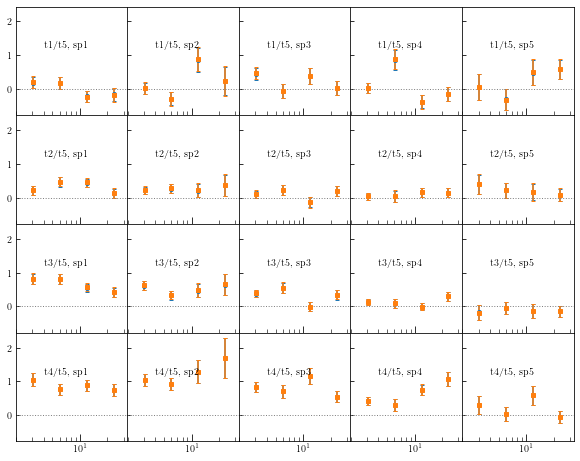

In [7]:
fig=plt.figure(figsize=(10,8))
axs = fig.subplots(nrows=ntomo-1, ncols=nspecz, sharex=True, sharey=True)
###adjustFigAspect(fig,aspect=.5)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
for i in range(nspecz):
    for j in range(ntomo-1):

        # For plotting we separate the data back into the different source-lens bin combinations
        minplt=i*(ntomo-1)*ntheta+ j*ntheta
        maxplt=minplt + ntheta

        thetas_to_plot = thetas[minplt:maxplt]
        gt_to_plot = gt_ratio[minplt:maxplt]
        gterr_to_plot = gt_ratio_err[minplt:maxplt]
        gt_to_plot_m = gt_ratio_m[minplt:maxplt]
        gterr_to_plot_m = gt_ratio_err_m[minplt:maxplt]
        #gterr_to_plot = gterr[minplt:maxplt]
        #to do the Dls/Ds functions!!!

        tmp_axs = axs[j,i]
        tmp_axs.set_xscale('log')
        tmp_axs.set_xlim(theta_min*0.99,theta_max*1.1)
        # tmp_axs.set_ylim(-0.0075,)

        tmp_axs.errorbar(thetas_to_plot, gt_to_plot, yerr=gterr_to_plot, fmt='o', capsize=2, markersize=4.,label='')
        tmp_axs.errorbar(thetas_to_plot, gt_to_plot_m, yerr=gterr_to_plot_m, fmt='s', capsize=2, markersize=4.,label='include m bias')
        # tmp_axs.plot(thetas_to_plot, gt_to_plot)
        # tmp_axs.plot(thetas_to_plot, thetas_to_plot*func_to_plot)

        tmp_axs.text(theta_min*2., 1.2, "t"+str(tomo_bins[j]+1)+"/t5, sp"+str(spec_bins[i]+1))
        tmp_axs.axhline(0., color='gray', linestyle=':', linewidth=1.)
        # tmp_axs.legend()
plt.show()

[0.18325377587171363, 0.2113555845608801, 0.8065075517434271, 1.045795263844863]
[0.16226116368608542, 0.4571623907020258, 0.8029937749631175, 0.7572955273289913]
[-0.22666371177103778, 0.4372570126005192, 0.5551636801114418, 0.8746913189387704]
[-0.16703580657069028, 0.12027654731143103, 0.41711271071736183, 0.7273286575612157]
[0.022152022406044424, 0.2154388935930003, 0.610868668446992, 1.0301135500119412]
[-0.2957109624890957, 0.26046331297857905, 0.3195308713773384, 0.9171270718232044]
[0.8591281256915246, 0.20721398539499888, 0.46507339381869145, 1.280209485874456]
[0.22855142304048767, 0.36150170929609954, 0.6404300012356356, 1.6847481362494336]
[0.45190659178244164, 0.09351758793969848, 0.3767070647354419, 0.8289092521430683]
[-0.06618527211383306, 0.2135323456065718, 0.5469781428780989, 0.697432888367317]
[0.38081564029697523, -0.14084896817485235, -0.015207332133132969, 1.1471336537173975]
[0.018240810098488002, 0.18497711194340405, 0.3328617006519628, 0.5399639339714246]
[0.

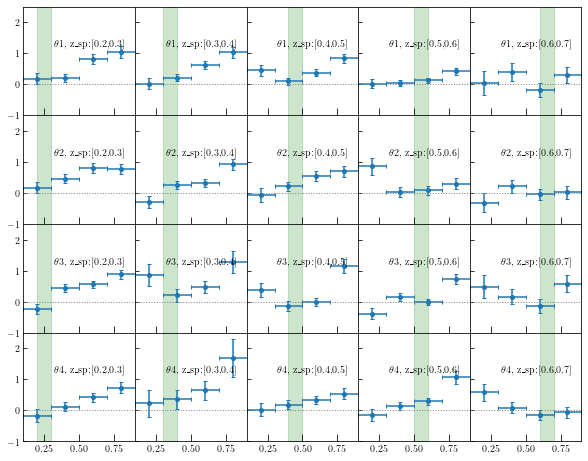

In [9]:
fig=plt.figure(figsize=(10,8))
axs = fig.subplots(nrows=ntheta, ncols=nspecz, sharex=True, sharey=True)
###adjustFigAspect(fig,aspect=.5)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
dat=open('Shear_Ratio.dat','w+')
ztomo=[0.2,0.4,0.6,0.8,1.05]
zsp=[0.2,0.3,0.4,0.5,0.6,0.7]
ztomoerr=[0.1,0.1,0.1,0.1,0.15]
ydense=np.linspace(-1,2.5,100)
for i in range(nspecz):
    for j in range(ntheta):

        # For plotting we separate the data back into the different source-lens bin combinations
        minplt=i*(ntomo-1)*ntheta+ j*ntheta
        maxplt=minplt + ntheta
        
        gt_to_plot=[]
        gterr_to_plot=[]

        for k in range(ntomo-1):
            gt_to_plot.append(gt_ratio[i*(ntomo-1)*ntheta+k*ntheta+j])
            gterr_to_plot.append(gt_ratio_err[i*(ntomo-1)*ntheta+k*ntheta+j])
            print(thetas[j],zsp[i],i,ztomo[k],k,gt_ratio[i*(ntomo-1)*ntheta+k*ntheta+j],gt_ratio_err[i*(ntomo-1)*ntheta+k*ntheta+j],file=dat)
        print(gt_to_plot)
        tmp_axs = axs[j,i]

        tmp_axs.errorbar(ztomo[:4], gt_to_plot, xerr=ztomoerr[:4],yerr=gterr_to_plot, fmt='o', capsize=2, markersize=4.)
        tmp_axs.fill_betweenx(ydense, zsp[i],zsp[i+1],color='green',alpha=0.2)
        tmp_axs.set_xlim(0.1,0.9)
        tmp_axs.set_ylim(-1,2.5)

        tmp_axs.text(ztomo[1]*0.8, 1.2, r"$\theta$"+str(j+1)+", z_sp:["+str(zsp[i])+','+str(zsp[i+1])+']')

        tmp_axs.axhline(0., color='gray', linestyle=':', linewidth=1.)
        # tmp_axs.legend()
plt.show()
dat.close()